In [1]:
# Import all the necessary files!
import os
from os.path import isfile, join
import tensorflow as tf
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
# importing matplotlib modules 
from PIL import Image 
import imghdr
import matplotlib.pyplot as plt 
import numpy as np

import spacy # for nlp similarity calculation

import warnings
warnings.filterwarnings("ignore")

In [55]:
# search all 'jepg' and 'npg' format image under a pathlist
def searchimg(pathlist):
    picpaths=[]
    for path in pathlist:
        for f in os.listdir(path):
            newpath=join(path, f)
            if isfile(newpath):
                if imghdr.what(newpath) in ['jpeg','png']:
                    picpaths.append(newpath)
            else:
                picpaths+=searchimg([newpath])
    return picpaths

In [56]:
pathlist=['../pictures/']
piclists=searchimg(pathlist)
print(piclists[:10],len(piclists))

['../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1784.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1787.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1792.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1795.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1875.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1877.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_1959.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_2026.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_2054.JPG', '../pictures/2015.8.22-2015.12.3\\from zhu\\IMG_2094.JPG'] 60


In [2]:
# define some parameters for processing the image
width,height,channel = 300,300,3

In [46]:
# import image and compress and rescale images
def imgprocess(path,width,height,angle=0,scale=1/255.):
    img = Image.open(path)  # load img from path
    img=img.resize((width,height), Image.ANTIALIAS) # resize img to (300,300)
    img=img.rotate(angle-90) # retate image as a lot of images are off 90 degree after imported
    img=np.array(img)*scale # rescale img for prediction
    #print(img.shape)
    return img

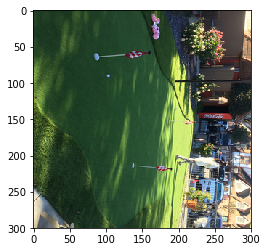

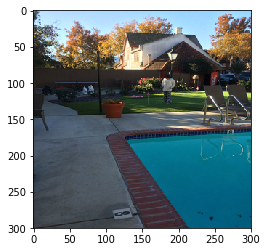

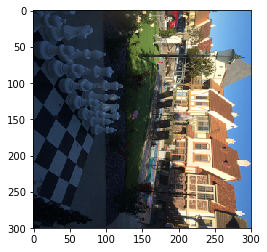

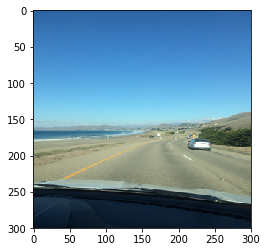

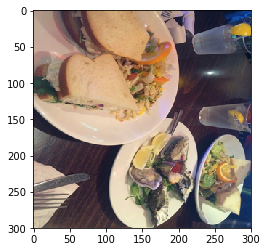

In [57]:
# have a look some reallife photo that i took in piclists
for picpath in piclists[:5]:
    img=imgprocess(picpath,width,height)
    plt.figure()
    plt.imshow(img) 


## the figure loads fine, but some are off 90 degree due to the way you held the camera,
## need to fix this later

In [3]:
# load inception v3 model,currently just use pretrained weights
# I may make the last few layer trainable in the future

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
pre_trained_model = InceptionV3(input_shape = (width,height,channel))
pre_trained_model.load_weights(local_weights_file)


In [50]:
# use pre_trained _model to classify a picture

def predict(picpath,**kwarg):
    img = imgprocess(picpath,width,height,**kwarg)
    feedimg = img.reshape(-1,width,height,channel) #will be shaped as (1,300,300,3)
    predict = pre_trained_model.predict(feedimg)
    decoded = tf.keras.applications.inception_v3.decode_predictions(predict, top=5) 
    #only top 5 likely items are kept
    return decoded

# lets classify some pictures 

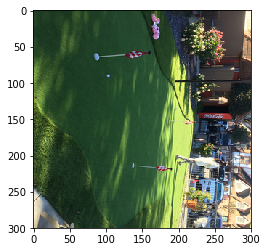

[[('n09229709', 'bubble', 0.2732394), ('n09332890', 'lakeside', 0.040103115), ('n03930313', 'picket_fence', 0.040032446), ('n04335435', 'streetcar', 0.03054806), ('n01737021', 'water_snake', 0.021012621)]]


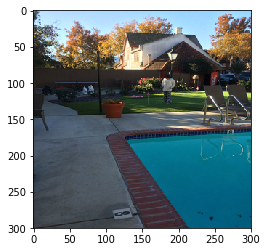

[[('n03899768', 'patio', 0.6733504), ('n03888605', 'parallel_bars', 0.03615756), ('n02777292', 'balance_beam', 0.029735986), ('n02807133', 'bathing_cap', 0.0137698045), ('n04258138', 'solar_dish', 0.013566897)]]


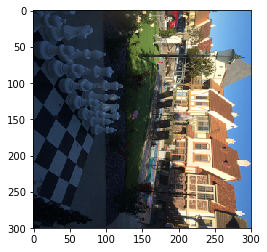

[[('n03598930', 'jigsaw_puzzle', 0.0645425), ('n02843684', 'birdhouse', 0.061824184), ('n03729826', 'matchstick', 0.054741025), ('n02971356', 'carton', 0.03166067), ('n02692877', 'airship', 0.024049247)]]


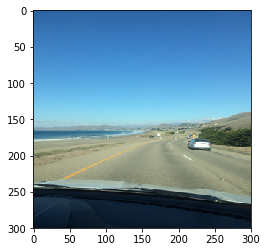

[[('n09421951', 'sandbar', 0.29276344), ('n04592741', 'wing', 0.15223598), ('n04037443', 'racer', 0.12912624), ('n04467665', 'trailer_truck', 0.030847669), ('n02974003', 'car_wheel', 0.013540691)]]


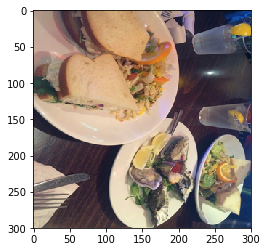

[[('n07880968', 'burrito', 0.42910218), ('n07579787', 'plate', 0.24607566), ('n07614500', 'ice_cream', 0.06272598), ('n07875152', 'potpie', 0.054655194), ('n07583066', 'guacamole', 0.026142607)]]


In [58]:
for picpath in piclists[:5]:
    img=imgprocess(picpath,width,height)
    plt.figure()
    plt.imshow(img) 
    plt.show()
    print(predict(picpath))

In [59]:
# The purpose is search a picture by some arbitary word
# spacy is a Natural language processing tool that can convert phrases to vectors 
# and compre the similarity between 2 phrases,which is nice

nlp = spacy.load('en_core_web_md')

class SearchByWord(object):
    
    def __init__(self,keyword=None):
        self.keyword=keyword
        self.doc=nlp(keyword)
        self._similar=0.
    
    def similarity(self,candidate):
        self._similar=self.doc.similarity(nlp(candidate))
        return self._similar


In [67]:
# lets have a test
keyword='tv'
key = SearchByWord(keyword)
print(key.similarity('television'),key.similarity('xbox'),key.similarity('computer display'))

0.7599257680029051 0.4411925289005514 0.3799884808412151


In [68]:
# combine all stuff together
# predict each picture and when the relavance between keyword and label is above relavance 
# show the picture

def searchImgByWord(keyword,pathlist,relevance=0.6):
    key = SearchByWord(keyword)
    picpaths = searchimg(pathlist)
    print('found %d pictures' %(len(picpaths)))
    
    for i in range(len(picpaths)):
        if i%50==49:
            print('finish %d / %d' %(i+1,len(picpaths)))
        picpath = picpaths[i]
        decoded = predict(picpath)
        similarities = []
        for _item in decoded[0]:
            label = _item[1]
            similarities.append(key.similarity(label))
        maxsimilarity = max(similarities)
        
        if maxsimilarity>relevance:
            print(picpath)
            print('similarity: %.2f' %maxsimilarity)
            plt.figure()
            img = imgprocess(picpath,width,height)
            plt.imshow(img)
            plt.show()
    

found 60 pictures
../pictures/2015.8.22-2015.12.3\IMG_1474.JPG
similarity: 0.76


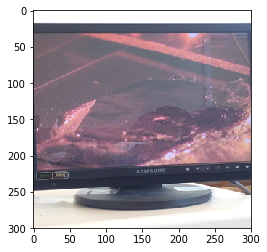

finish 50 / 60
../pictures/pic1\IMG_3453.JPG
similarity: 0.76


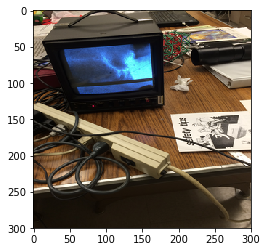

In [73]:
# make a tests

pathlist=['../pictures/']
searchImgByWord('tv',pathlist)
        

## found 2 images, which look quite like tvs

[[('n03179701', 'desk', 0.29043904), ('n02776631', 'bakery', 0.09092477), ('n04264628', 'space_bar', 0.06440575), ('n03180011', 'desktop_computer', 0.055252768), ('n03085013', 'computer_keyboard', 0.03847793)]]


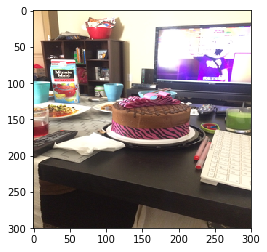

In [74]:
# it acctually missed 1 images
# the tv is classified as 'desktop_computer'
# the relavence shredhold should be adjusted
img=imgprocess('../pictures/2015.8.22-2015.12.3/IMG_1481.JPG',width,height)
plt.imshow(img)
print(predict('../pictures/2015.8.22-2015.12.3/IMG_1481.JPG'))


found 60 pictures
../pictures/2015.8.22-2015.12.3\IMG_1474.JPG
similarity: 0.68


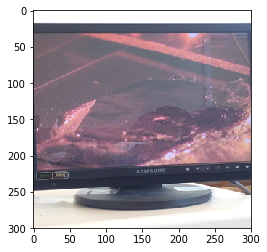

../pictures/2015.8.22-2015.12.3\IMG_1481.JPG
similarity: 0.50


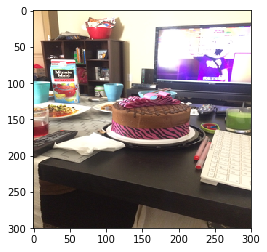

finish 50 / 60
../pictures/pic1\IMG_3453.JPG
similarity: 0.68


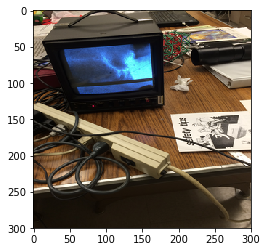

In [84]:
# use more ambiguous words and decrease relavance could fix it
# but smarter way should be implemented

searchImgByWord('TV,monitor,computer',pathlist,0.5)

found 60 pictures
../pictures/2015.8.22-2015.12.3\IMG_1399.JPG
similarity: 0.53


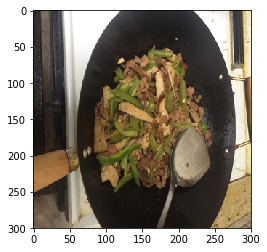

../pictures/pic1\IMG_1726.JPG
similarity: 0.53


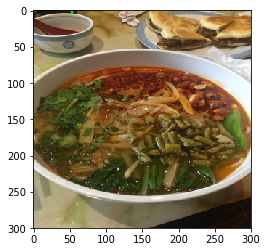

finish 50 / 60


In [85]:
# try something else
searchImgByWord('mug',pathlist,0.5)

[[('n04086273', 'revolver', 0.3110605),
  ('n07248320', 'book_jacket', 0.02939838),
  ('n03492542', 'hard_disc', 0.02845337),
  ('n03483316', 'hand_blower', 0.022052055),
  ('n03777754', 'modem', 0.016462335)]]

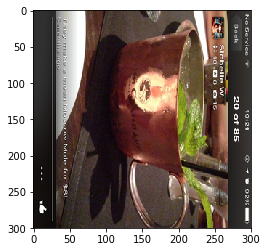

In [89]:
#completely missed the pic below due to the rotation
img=imgprocess('../pictures/pic1/IMG_2305.PNG',width,height)
plt.imshow(img)
predict('../pictures/pic1/IMG_2305.PNG')

[[('n06359193', 'web_site', 0.14554869),
  ('n03259280', 'Dutch_oven', 0.04999523),
  ('n03063599', 'coffee_mug', 0.049815375),
  ('n02939185', 'caldron', 0.04854733),
  ('n07930864', 'cup', 0.03630014)]]

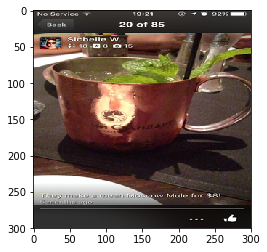

In [93]:
img=imgprocess('../pictures/pic1/IMG_2305.PNG',width,height,90)
plt.imshow(img)
predict('../pictures/pic1/IMG_2305.PNG',angle=90)

In [33]:
# tempararily I will just predict each picture twice, one rotates and one doesn't

In [128]:
def searchImgByWord(keyword,pathlist,relevance=0.6,angles=[0,90]):
    key = SearchByWord(keyword)
    picpaths = searchimg(pathlist)
    print('found %d pictures' %(len(picpaths)))
    
    for i in range(len(picpaths)):
        if i%50==49:
            print('finish %d / %d' %(i+1,len(picpaths)))
        picpath = picpaths[i]
        similarities = []
        # use 2 angles here
        for _ in angles:
            decoded = predict(picpath,angle=_)
            for _item in decoded[0]:
                label = _item[1]
                similarities.append(key.similarity(label))
        maxsimilarity = max(similarities)
        
        if maxsimilarity>relevance:
            print(picpath)
            print('similarity: %.2f' %maxsimilarity)
            plt.figure()
            img = imgprocess(picpath,width,height)
            plt.imshow(img)
            plt.show()

found 60 pictures
finish 50 / 60
../pictures/pic1\IMG_3201.JPG
similarity: 1.00


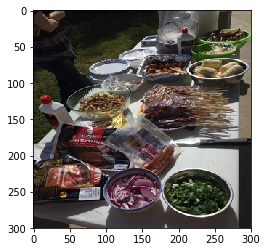

In [95]:
searchImgByWord('mug',pathlist,0.6)

### still missing..hmmm

In [109]:
# the label of inception model is affecting
# spacy seems doesn't support '_'
print(SearchByWord('coffee mug').similarity('mug'))
print(SearchByWord('coffee_mug').similarity('mug'))

0.8796358323418045
0.0


In [111]:
# so adjust the class
class SearchByWord(object):
    
    def __init__(self,keyword=None):
        self.keyword=keyword.replace('_',' ')
        self.doc=nlp(self.keyword)
        self._similar=0.
    
    def similarity(self,candidate):
        cadidate=candidate.replace('_',' ')
        self._similar=self.doc.similarity(nlp(cadidate))
        return self._similar


In [112]:
print(SearchByWord('coffee_mug').similarity('mug'))

0.8796358323418045


found 60 pictures
../pictures/2015.8.22-2015.12.3\IMG_1593.JPG
similarity: 0.60


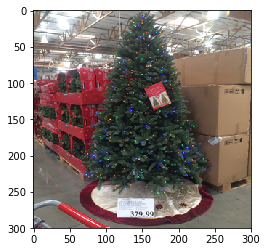

../pictures/pic1\IMG_2305.PNG
similarity: 0.88


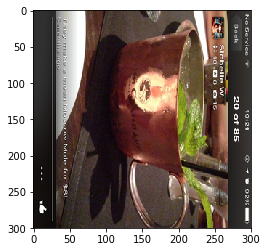

finish 50 / 60
../pictures/pic1\IMG_3201.JPG
similarity: 1.00


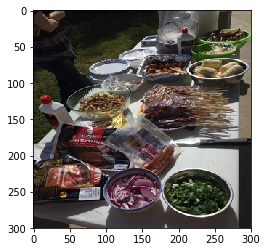

In [114]:
# try again
searchImgByWord('mug',pathlist,0.6)


found 60 pictures
../pictures/2015.8.22-2015.12.3\from zhu\IMG_1792.JPG
similarity: 0.64


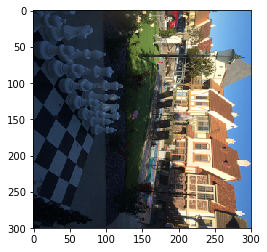

../pictures/2015.8.22-2015.12.3\from zhu\IMG_2026.JPG
similarity: 0.62


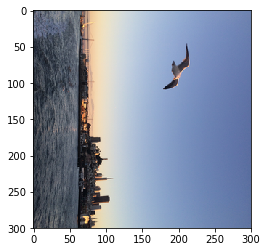

../pictures/pic1\IMG_2028.JPG
similarity: 1.00


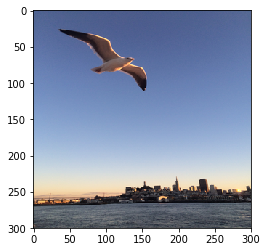

finish 50 / 60
../pictures/pic2\IMG_1907.JPG
similarity: 0.64


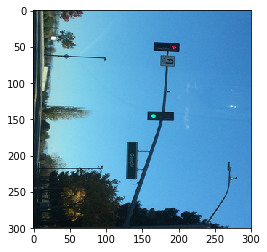

In [131]:
# one more
searchImgByWord('bird',pathlist,0.6)

#### works better now

# TO DOs

#### 1. there are 1000 class in the inception v3 model, i should make the last few layers trainable to classify unique objects.

#### 2. the predicted classification can be stored in a doc to avoid repeated predict each time

#### 3. the relavance thredhold should be adjusted smartly ( for example, the top 10 relavant labels in the 1000 classes)

#### 4. The picture can be divided to segments for prediction and increase accuracy

#### 5. better organize the code....